# Combining Sketch & Tone for Pencil Drawing Production


We can divide the method into 2 main steps:
1. Pencil stroke generation (captures the general strucure of the scene)
2. Pencil tone drawing (captures shapes shadows and shading)

Combining the results from these two steps should yield the desired result.


### Line Drawing with Strokes
The initial step is to smooth the image using a smoothing filter, Median and Gaussian should do the trick.

In this method, we approximate sketchy lines by determining the direction, length and width in  a pixel classification. The classification is done by computing the gradients on the grayscale version of the input image (or the Y - brightness channel in YUV space) to yield the magnitude (we can use 2 methods: Sobel and the regular way): $$ G = \sqrt{(\partial_xI)^2 + (\partial_yI)^2} $$
Then, we choose a number of directions, 8 in our case, which serve as reference directions, from them we create 8 line segements the act as convolurional kernels. The kernel's size is usually set to be 1/30 of the input image's height/width. We denote thos line segements by $ L_i, i \in [1..8] $

Using these kernels, we create response map for each direction using the convolution operation: $$ G_i = L_i \otimes G $$
We now can perform the classification - selecting the maximum value among the responses in all directions:
$$ C_i(p) =
  \begin{cases}
    G(p)       & \quad \text{if } argmax_i(G_i(p))=i \\
    0  & \quad \text{else}
  \end{cases}
$$
p indexes pixels (we work pixel-by-pixel), $C_i$ is the magnitude map for direction $i$. It suffices that: $$\sum_{i=1}^{8}C_i = G $$
We reach the last part of the line drawing, which is Line Shaping - given the map set {$C_i$}, we generate lines at each pixel using convolution as follows: $$ S' = \sum_{i=1}^{8} L_i \otimes C_i $$ This links edge pixels that are not even connected in the original gradient map.

The final pencil stroke map S: Invert pixel values of S' and map to [0,1].


In [1]:
import numpy as np
import cv2
from skimage import io, color, filters, transform, exposure
from scipy import signal, sparse
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Generate Stroke Map

def gen_stroke_map(img, kernel_size, stroke_width=0, num_of_directions=8, smooth_kernel="gauss", gradient_method=0):
    height = img.shape[0] 
    width = img.shape[1] 
    
    if (smooth_kernel == "gauss"):
        smooth_im = filters.gaussian(img, sigma=np.sqrt(2))
    else:
        smooth_im = filters.median(img) 
    # calculate the gradients:
    
    if not gradient_method:
        imX = np.zeros_like(img)
        diffX = img[: , 1:width] - img[: , 0:width - 1]
        imX[:, 0:width - 1] = diffX
        imY = np.zeros_like(img)
        diffY = img[1:height , :] - img[0:height - 1 , :]
        imY[0:height - 1, :] = diffY
        G = np.sqrt(np.square(imX) + np.square(imY))
    else:
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
        sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
        G = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # create the basic line segement (horizontal)

    basic_ker = np.zeros((kernel_size * 2 + 1, kernel_size * 2 + 1))
    basic_ker[kernel_size + 1,:] = 1 
    
    # rotate the lines in the given directions and perform the classification:
    res_map = np.zeros((height, width, num_of_directions))
    for d in range(num_of_directions):
        ker = transform.rotate(basic_ker, (d * 180) / num_of_directions)
        res_map[:,:, d] = signal.convolve2d(G, ker, mode='same')
    max_pixel_indices_map = np.argmax(res_map, axis=2)

    # compute the Classification map:
    C = np.zeros_like(res_map)
    for d in range(num_of_directions):
        C[:,:,d] = G * (max_pixel_indices_map == d) 
    
    # stroke width
    if not stroke_width:
        for w in range(1, stroke_width + 1):
            if (kernel_size + 1 - w) >= 0:
                basic_ker[kernel_size + 1 - w, :] = 1
            if (kernel_size + 1 + w) < (kernel_size * 2 + 1):
                basic_ker[kernel_size + 1 + w, :] = 1
    
    # compute S
    S_tag_sep = np.zeros_like(C)
    for d in range(num_of_directions):
        ker = transform.rotate(basic_ker, (d * 180) / num_of_directions)
        S_tag_sep[:,:,d] = signal.convolve2d(C[:,:,d], ker, mode='same')
    S_tag = np.sum(S_tag_sep, axis=2)
    S_tag_normalized = (S_tag - np.min(S_tag.ravel())) / (np.max(S_tag.ravel()) - np.min(S_tag.ravel()))
    S = 1 - S_tag_normalized
    return S
    

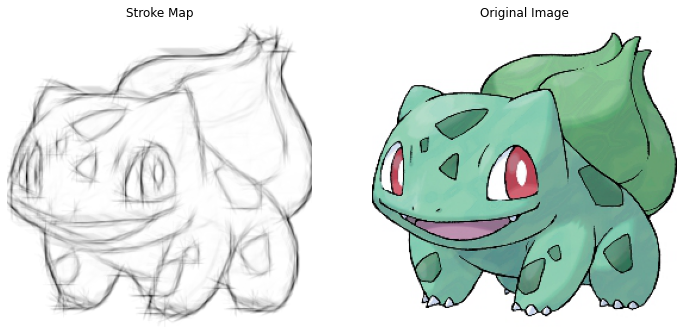

In [6]:
# an example of Stroke Map:
ex_img = io.imread('./pokemon/1.jpg')
ex_img_yuv = color.rgb2yuv(ex_img)
ex_img_y_ch = ex_img_yuv[:,:,0]
ex_img_stroke_map = gen_stroke_map(ex_img_y_ch, kernel_size=8, stroke_width=1,
                                   num_of_directions=8, smooth_kernel="gauss", gradient_method=1)
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,1)
plt.imshow(ex_img_stroke_map, cmap='gray')
plt.axis('off')
plt.title('Stroke Map')
plt.subplot(1,2,2)
plt.imshow(ex_img)
plt.axis('off')
plt.title('Original Image')
plt.show()

### Tone Map Generation
We define 3 main tones: bright (b), mild (m), dark (d).

This method is called "Model-based Tone Transfer) - we use a parametric model to represent the target tone distribution:
$$ p(v) = \frac{1}{Z}\sum_{i=1}^{3}\omega_ip_i(v) $$ where v is the tone value, p(v) is the probability that a pixel in a pencil drawing is with value v and $\omega_i$ is the weight that corresponds to the number of pixels in each layer. Z is a normalization parameter to keep the probability in the safe region. We later define 3 groups of empirically tested $ \omega_i$'s.

* For the bright (b) layer, we use Laplacian distribution: $$ p_1(v) =
  \begin{cases}
    \frac{1}{\sigma_b}e^{-\frac{1 - v}{\sigma_b}}       & \quad \text{if } v \leq 1 \\
    0  & \quad \text{else}
  \end{cases}
$$ where $\sigma_b$ is the scale of the distribution (learned parameter, calculated later)

* For the mild (m) layer, we use uniform distribution: $$ p_2(v) =
  \begin{cases}
    \frac{1}{u_b - u_a}       & \quad \text{if } u_a \leq v \leq u_b \\
    0  & \quad \text{else}
  \end{cases}
$$ where $u_a$, $u_b$ are the ranges of the distribution (calculated later)

* For the dark (d) tone, we use Gaussian distribution: $$ p_3(v) = \frac{1}{\sqrt{2\pi\sigma_d}}e^{-\frac{(v-\mu_d)^2}{2\sigma_d^2}} $$ where $\sigma_d$ is the scale of the distribution (learned parameter, calculated later)

#### Parameter Learning based on MLE (Maximum Likelihood)
We define:
* m := mean of pixel values in each layer
* s:= STD of pixel values in each layer
* $x_i$ := pixel value
* N := number of pixels in the layer
Using MLE, we get the following results:
$$ \sigma_b = \frac{1}{N}\sum_{i=1}^{N}|x_i - 1| $$ $$ u_a = m_m - \sqrt{3}s_m , u_a = m_m + \sqrt{3}s_m $$ $$\mu_d = m_d, \sigma_d = s_d $$

The weights are divided into 3 groups:
$$ \omega_1:\omega_2:\omega_3 = 11:37:52 $$
$$ \omega_1:\omega_2:\omega_3 = 29:29:42 $$
$$ \omega_1:\omega_2:\omega_3 = 2:22:76 $$

The result image J is the tone adjusted input image, using histogram equaliztion.

For simplicity, we will use general parameters as in the paper.

In [7]:
# Generate Tone Map

def gen_tone_map(img, w_group=0):
    # calculate the parameters and define weight groups
    w_mat = np.array([[11, 37, 52],
                     [29, 29, 42],
                     [2, 22, 76]])
    w = w_mat[w_group,:]
    
    # for the mild layer:
    u_b = 225
    u_a = 105
    # for the bright layer:
    sigma_b = 9
    # for the dark layer:
    mu_d = 90
    sigma_d = 11
    
    # calculate the new histogram (p(v)):
    num_pixel_vals = 256
    p = np.zeros(num_pixel_vals)
    for v in range(num_pixel_vals):
        p1 = (1 / sigma_b) * np.exp(-(255 - v) / sigma_b)
        if (u_a <= v <= u_b):
            p2 = 1 / (u_b - u_a)
        else:
            p2 = 0
        p3 = (1 / np.sqrt(2 * np.pi * sigma_d)) * np.exp( (-np.square(v - mu_d)) / (2 * np.square(sigma_d)) )
        p[v] = w[0] * p1 + w[1] * p2 + w[2] * p3 * 0.01
    p_normalized = p / np.sum(p)
    P = np.cumsum(p_normalized)
    h = exposure.histogram(img, nbins=256)
    H = np.cumsum(h / np.sum(h))
    lut = np.zeros_like(p)
    for v in range(num_pixel_vals):
        dist = np.abs(P - H[v])
        argmin_dist = np.argmin(dist)
        lut[v] = argmin_dist
    lut_normalized = lut / num_pixel_vals
    J = lut_normalized[(255 * img).astype(np.int)]

    J_smoothed = filters.gaussian(J, sigma=np.sqrt(2))
    return J_smoothed
    

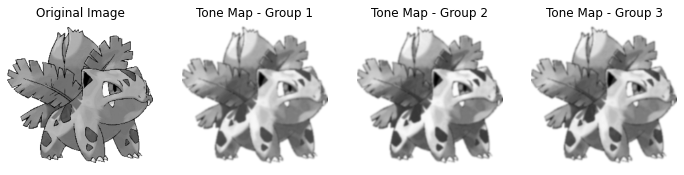

In [9]:
# an example of Tone Map:
ex_img = io.imread('./pokemon/2.jpg')
ex_img_yuv = color.rgb2yuv(ex_img)
ex_img_y_ch = ex_img_yuv[:,:,0]
ex_img_tone_map_0 = gen_tone_map(ex_img_y_ch, w_group=0)
ex_img_tone_map_1 = gen_tone_map(ex_img_y_ch, w_group=1)
ex_img_tone_map_2 = gen_tone_map(ex_img_y_ch, w_group=2)
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,4,1)
plt.imshow(ex_img_y_ch, cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(ex_img_tone_map_0, cmap='gray')
plt.axis('off')
plt.title('Tone Map - Group 1')

plt.subplot(1,4,3)
plt.imshow(ex_img_tone_map_1, cmap='gray')
plt.axis('off')
plt.title('Tone Map - Group 2')

plt.subplot(1,4,4)
plt.imshow(ex_img_tone_map_2, cmap='gray')
plt.axis('off')
plt.title('Tone Map - Group 3')

plt.show()

### Pencil Texture Rendering
Given H - real pencil textures, we wish to learn human-drawn tonal patterns. In real-life, those are generated by repeadtly drawing at the same place. We will use five types located in "pencils" folder. 

In the process we are using multiplication of H's to find an approximation for J such that:
$$ H(x)^{\beta(x)} \approx J(x) $$ or in the log-domain:
$$ {\beta(x)}log(H(x)) \approx log(J(x)) $$


The final pencil texture map T:
$$ T = H^{\beta^*} $$

In [10]:
# Generate Pencil Texture:
def gen_pencil_texture(img, H, J):
    lamda = 0.2
    height = img.shape[0]
    width = img.shape[1]

    # H_res = transform.resize(H,(height, width))
    H_res = cv2.resize(H, (width, height), interpolation=cv2.INTER_CUBIC)
    H_res_reshaped = np.reshape(H_res, (height * width, 1))
    logH = np.log(H_res_reshaped)
    
    # J_res = transform.resize(J,(height, width))
    J_res = cv2.resize(J, (width, height), interpolation=cv2.INTER_CUBIC)
    J_res_reshaped = np.reshape(J_res, (height * width, 1))
    logJ = np.log(J_res_reshaped)
    
    logH_sparse = sparse.spdiags(logH.ravel(), 0, height*width, height*width) 
    e = np.ones((height * width, 1))
    ee = np.concatenate((-e,e), axis=1)
    diags_x = [0, height*width]
    diags_y = [0, 1]
    dx = sparse.spdiags(ee.T, diags_x, height*width, height*width)
    dy = sparse.spdiags(ee.T, diags_y, height*width, height*width)
    
    # Compute matrix X and b:
    A = lamda * ((dx @ dx.T) + (dy @ dy.T)) + logH_sparse.T @ logH_sparse
    b = logH_sparse.T @ logJ
    
    # Conjugate Gradient
    beta = sparse.linalg.cg(A, b, tol=1e-6, maxiter=60)
    
    beta_reshaped = np.reshape(beta[0], (height, width))
    
    # The final pencil texture map T
    T = np.power(H_res, beta_reshaped)
    
    return T
    

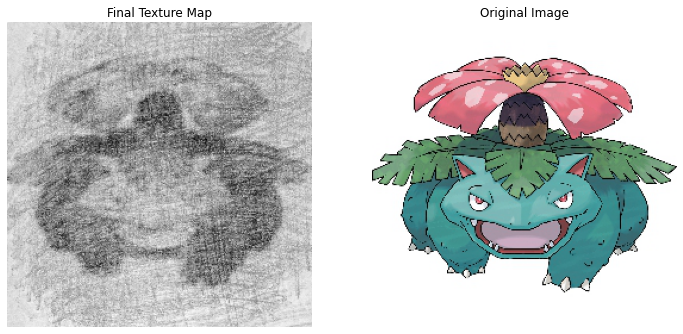

In [11]:
# an example of Pencil Texture Map:
ex_img = io.imread('./pokemon/3.jpg')
ex_img_yuv = color.rgb2yuv(ex_img)
ex_img_y_ch = ex_img_yuv[:,:,0]
pencil_tex = io.imread('./pencils/pencil0.jpg', as_gray=True)
ex_img_tone_map_0 = gen_tone_map(ex_img_y_ch, w_group=0)
ex_img_tex_map = gen_pencil_texture(ex_img_y_ch, pencil_tex, ex_img_tone_map_0)

plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1,2,1)
plt.imshow(ex_img_tex_map, cmap='gray')
plt.axis('off')
plt.title('Final Texture Map')

plt.subplot(1,2,2)
plt.imshow(ex_img)
plt.axis('off')
plt.title('Original Image')

plt.show()

### Combine Everything
The final step is to combine all of the results from previous steps as follows:
$$ R = S \times T $$
where R is brightness channel in the YUV space, or the final omage in case the image is grayscale

In [12]:

def gen_pencil_drawing(img, kernel_size, stroke_width=0, num_of_directions=8, smooth_kernel="gauss",
                       gradient_method=0, rgb=False, w_group=0, pencil_texture_path="", stroke_darkness=1, tone_darkness=1):
    if not rgb:
        im = img
    else:
        yuv_img = color.rgb2yuv(img)
        im = yuv_img[:,:,0]
    # Generate the Stroke Map:
    S = gen_stroke_map(im, kernel_size, stroke_width=stroke_width, num_of_directions=num_of_directions,
                       smooth_kernel=smooth_kernel, gradient_method=gradient_method)
    S = np.power(S, stroke_darkness)
    
    # Generate the Tone Map:
    J = gen_tone_map(im, w_group=w_group)
    
    # Read the pencil texture:
    if not pencil_texture_path:
        pencil_texture = io.imread('./pencil0.jpg', as_gray=True)
    else:
        pencil_texture = io.imread(pencil_texture_path, as_gray=True)
    
    # Generate the Pencil Texture Map:
    T = gen_pencil_texture(im, pencil_texture, J)
    T = np.power(T, tone_darkness)
    
    # The final Y channel:
    R = np.multiply(S, T)
    
    if not rgb:
        return R
    else:
        yuv_img[:,:,0] = R
        return exposure.rescale_intensity(color.yuv2rgb(yuv_img), in_range=(0, 1))

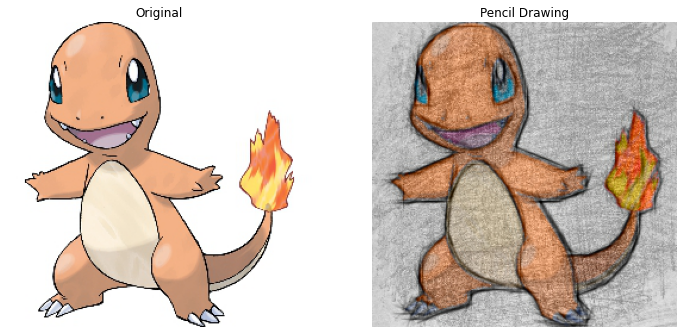

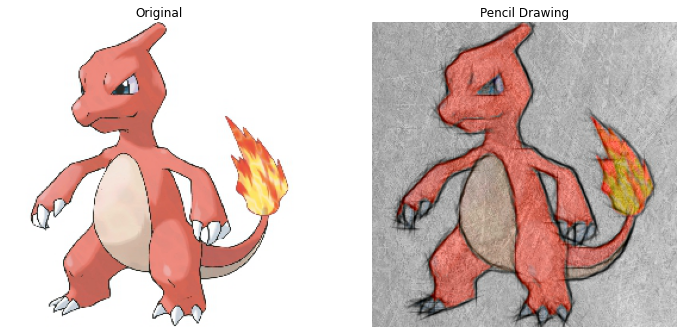

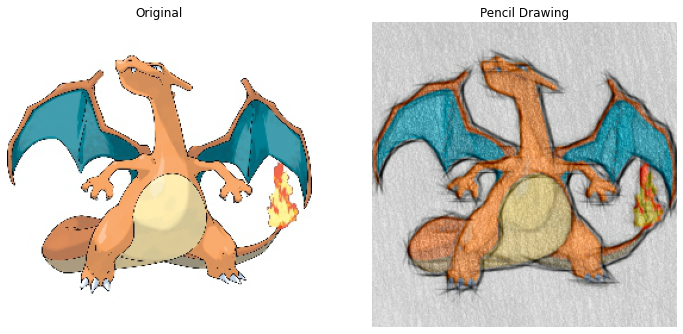

In [14]:
# some results
plt.subplot(1,2,1)
ex_img = io.imread('./pokemon/4.jpg')
pencil_tex = './pencils/pencil0.jpg'
ex_im_pen = gen_pencil_drawing(ex_img, kernel_size=8, stroke_width=1, num_of_directions=8, smooth_kernel="gauss",
                       gradient_method=1, rgb=True, w_group=2, pencil_texture_path=pencil_tex,
                               stroke_darkness= 2,tone_darkness=1.5)
plt.imshow(ex_img)
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(ex_im_pen)
plt.axis("off")
plt.title("Pencil Drawing")
plt.show()

plt.subplot(1,2,1)
ex_img = io.imread('./pokemon/5.jpg')
pencil_tex = './pencils/pencil1.jpg'
ex_im_pen = gen_pencil_drawing(ex_img, kernel_size=8, stroke_width=2, num_of_directions=8, smooth_kernel="median",
                       gradient_method=0, rgb=True, w_group=0, pencil_texture_path=pencil_tex,
                               stroke_darkness= 2,tone_darkness=1.5)
plt.imshow(ex_img)
plt.axis("off")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(ex_im_pen)
plt.axis("off")
plt.title("Pencil Drawing")
plt.show()

plt.subplot(1,2,1)
ex_img = io.imread('./pokemon/6.jpg')
pencil_tex = './pencils/pencil2.png'
ex_im_pen = gen_pencil_drawing(ex_img, kernel_size=8, stroke_width=0, num_of_directions=8, smooth_kernel="gauss",
                       gradient_method=1, rgb=True, w_group=1, pencil_texture_path=pencil_tex,
                               stroke_darkness= 2,tone_darkness=1.5)
plt.imshow(ex_img)
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)

plt.imshow(ex_im_pen)
plt.axis("off")
plt.title("Pencil Drawing")
plt.show()